In [1]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sacrebleu.metrics import CHRF
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [2]:
DATA_PATH = "../data/grammar_valid.csv"

def load_data_from_csv(path, max_samples=1000):
    df = pd.read_csv(path)
    df = df.dropna(subset=["source", "target"])
    df = df.sample(n=min(max_samples, len(df)), random_state=4011)
    pairs = list(zip(df["source"].tolist(), df["target"].tolist()))
    return pairs

pairs = load_data_from_csv(DATA_PATH, max_samples=1000)
sources = [pair[0] for pair in pairs]
targets = [pair[1] for pair in pairs]

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
t5_tokenizer = AutoTokenizer.from_pretrained("t5-grammar-small")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("t5-grammar-small").to(device)

bart_tokenizer = AutoTokenizer.from_pretrained("distilbart-grammar")
bart_model = AutoModelForSeq2SeqLM.from_pretrained("distilbart-grammar").to(device)

bart_model.generation_config.decoder_start_token_id = bart_tokenizer.bos_token_id
bart_model.generation_config.forced_bos_token_id = bart_tokenizer.bos_token_id
bart_model.generation_config.early_stopping = True

t5_model.eval()
bart_model.eval()

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/opt/miniconda3/envs/stat4011/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        

In [4]:
def batch_predict(model, tokenizer, inputs, model_name, batch_size=32):
    predictions = []
    num_batches = (len(inputs) + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches), desc=f"Predicting {model_name}"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(inputs))
        batch = inputs[start_idx:end_idx]
        
        encoded = tokenizer(
            batch, 
            padding=True, 
            truncation=True, 
            max_length=128, 
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            gen_kwargs = {
                "max_length": 128,
                "min_length": 1,
                "num_beams": 4,
                "length_penalty": 1.0, 
                "early_stopping": True,
                "pad_token_id": tokenizer.pad_token_id,
                "eos_token_id": tokenizer.eos_token_id,
            }
            
            if "bart" in model_name.lower():
                if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id is not None:
                    gen_kwargs["decoder_start_token_id"] = tokenizer.bos_token_id
                if hasattr(tokenizer, 'forced_bos_token_id'):
                    gen_kwargs["forced_bos_token_id"] = tokenizer.forced_bos_token_id
            
            generated_tokens = model.generate(**encoded, **gen_kwargs)
        
        decoded = tokenizer.batch_decode(
            generated_tokens, 
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=True
        )
        predictions.extend(decoded)
    
    return predictions

In [5]:
t5_inputs = []
for source in sources:
    t5_inputs.append("grammar: " + source)

bart_inputs = sources

t5_predictions = batch_predict(t5_model, t5_tokenizer, t5_inputs, "T5")
bart_predictions = batch_predict(bart_model, bart_tokenizer, bart_inputs, "BART")

Predicting BART: 100%|██████████| 32/32 [01:36<00:00,  3.02s/it]


In [6]:
chrf_metric = CHRF()

t5_chrf_scores = []
for pred, target in tqdm(zip(t5_predictions, targets), total=len(targets), desc="T5 chrF"):
    score = chrf_metric.sentence_score(pred, [target]).score
    t5_chrf_scores.append(score)

bart_chrf_scores = []
for pred, target in tqdm(zip(bart_predictions, targets), total=len(targets), desc="BART chrF"):
    score = chrf_metric.sentence_score(pred, [target]).score
    bart_chrf_scores.append(score)

t5_corpus_chrf = chrf_metric.corpus_score(t5_predictions, [targets])
bart_corpus_chrf = chrf_metric.corpus_score(bart_predictions, [targets])

BART chrF: 100%|██████████| 1000/1000 [00:00<00:00, 10423.30it/s]


In [7]:
results_df = pd.DataFrame({
    "source": sources,
    "target": targets,
    "t5_prediction": t5_predictions,
    "bart_prediction": bart_predictions,
    "t5_chrf": t5_chrf_scores,
    "bart_chrf": bart_chrf_scores
})

results_df["chrf_delta"] = results_df["t5_chrf"] - results_df["bart_chrf"]

results_df.head()

,source,target,t5_prediction,bart_prediction,t5_chrf,bart_chrf,chrf_delta
0,to written dialy everyday: ),to write a daily diary every day: ),to write daily daily: ),i have been learning english for a long time.,39.431302,10.125394,29.305907
1,"When I went there the last , it was in my birt...","When I went there the last , it was on my birt...","When I went there the last, it was in my birth...",i have been learning english for a long time.,94.321050,9.554268,84.766781
2,"anyway, i'll travel to the mountains by train ...","anyway, i'll travel to the mountains by train ...","anyway, i'll travel to the mountains by train ...",i have been learning english for a long time.,93.206219,13.731479,79.474740
3,I really love to learn English lounge & French...,I really love to learn English lounge & French...,I really love to learn English lounge & French...,i have been learning english for a long time.,90.891674,17.356515,73.535160
4,the moment i touched the most is soundless szp...,the moment i touched the most was szpilman's s...,the moment i touched the most is the soundless...,i have been learning english for a long time.,81.844532,9.398259,72.446273


In [8]:
print(f"T5 Corpus chrF: {t5_corpus_chrf.score:.2f}")
print(f"BART Corpus chrF: {bart_corpus_chrf.score:.2f}")

print(f"T5 Average chrF: {results_df['t5_chrf'].mean():.2f}")
print(f"BART Average chrF: {results_df['bart_chrf'].mean():.2f}")

T5 Corpus chrF: 88.00
BART Corpus chrF: 11.30
T5 Average chrF: 84.50
BART Average chrF: 12.68


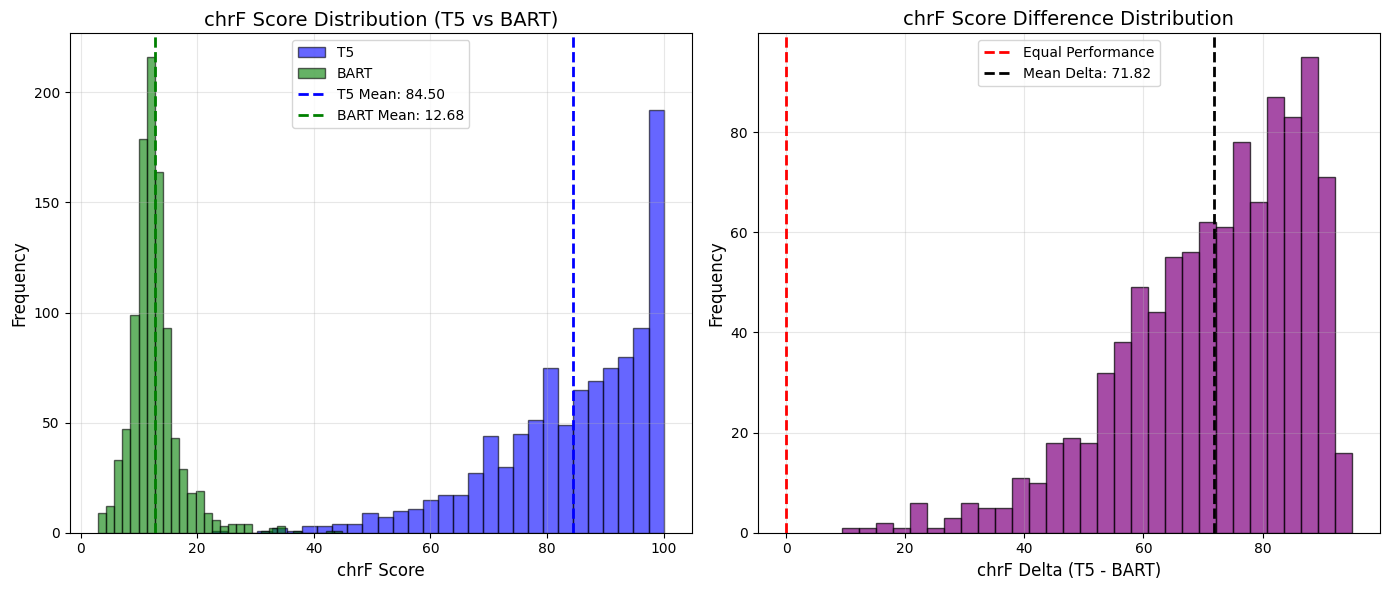

In [9]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(results_df["t5_chrf"], bins=30, alpha=0.6, label="T5", color="blue", edgecolor="black")
plt.hist(results_df["bart_chrf"], bins=30, alpha=0.6, label="BART", color="green", edgecolor="black")
plt.axvline(results_df["t5_chrf"].mean(), color="blue", linestyle="--", linewidth=2, 
            label=f"T5 Mean: {results_df['t5_chrf'].mean():.2f}")
plt.axvline(results_df["bart_chrf"].mean(), color="green", linestyle="--", linewidth=2, 
            label=f"BART Mean: {results_df['bart_chrf'].mean():.2f}")
plt.xlabel("chrF Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("chrF Score Distribution (T5 vs BART)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(results_df["chrf_delta"], bins=30, alpha=0.7, color="purple", edgecolor="black")
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="Equal Performance")
plt.axvline(results_df["chrf_delta"].mean(), color="black", linestyle="--", linewidth=2,
            label=f"Mean Delta: {results_df['chrf_delta'].mean():.2f}")
plt.xlabel("chrF Delta (T5 - BART)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("chrF Score Difference Distribution", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
threshold = 70.0

y_true_chr = np.ones(len(results_df), dtype=int)
y_pred_t5_chr = (results_df["t5_chrf"] >= threshold).astype(int)
y_pred_bart_chr = (results_df["bart_chrf"] >= threshold).astype(int)

# T5
cm_t5_chr = confusion_matrix(y_true_chr, y_pred_t5_chr, labels=[0, 1])
acc_t5_chr = accuracy_score(y_true_chr, y_pred_t5_chr)
prec_t5_chr = precision_score(y_true_chr, y_pred_t5_chr, pos_label=1, zero_division=0)
rec_t5_chr = recall_score(y_true_chr, y_pred_t5_chr, pos_label=1, zero_division=0)
f1_t5_chr = f1_score(y_true_chr, y_pred_t5_chr, pos_label=1, zero_division=0)

print("T5 chrF-based Metrics")
print(f"Accuracy: {acc_t5_chr * 100:.2f}%")
print(f"Precision: {prec_t5_chr * 100:.2f}%")
print(f"Recall: {rec_t5_chr * 100:.2f}%")
print(f"F1 Score: {f1_t5_chr * 100:.2f}%")

# BART
cm_bart_chr = confusion_matrix(y_true_chr, y_pred_bart_chr, labels=[0, 1])
acc_bart_chr = accuracy_score(y_true_chr, y_pred_bart_chr)
prec_bart_chr = precision_score(y_true_chr, y_pred_bart_chr, pos_label=1, zero_division=0)
rec_bart_chr = recall_score(y_true_chr, y_pred_bart_chr, pos_label=1, zero_division=0)
f1_bart_chr = f1_score(y_true_chr, y_pred_bart_chr, pos_label=1, zero_division=0)

print("BART chrF-based Metrics")
print(f"Accuracy: {acc_bart_chr * 100:.2f}%")
print(f"Precision: {prec_bart_chr * 100:.2f}%")
print(f"Recall: {rec_bart_chr * 100:.2f}%")
print(f"F1 Score: {f1_bart_chr * 100:.2f}%")

T5 chrF-based Metrics
Accuracy: 85.60%
Precision: 100.00%
Recall: 85.60%
F1 Score: 92.24%
BART chrF-based Metrics
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


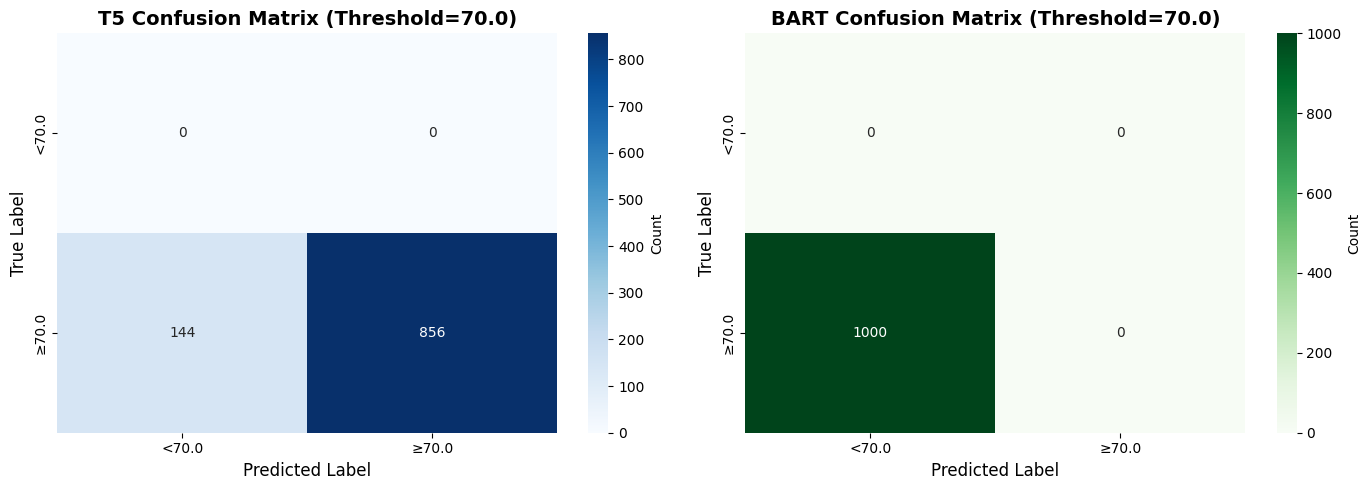

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# T5 Confusion Matrix
sns.heatmap(cm_t5_chr, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=[f"<{threshold}", f"≥{threshold}"],
            yticklabels=[f"<{threshold}", f"≥{threshold}"],
            cbar_kws={'label': 'Count'})
axes[0].set_title(f"T5 Confusion Matrix (Threshold={threshold})", fontsize=14, fontweight='bold')
axes[0].set_ylabel("True Label", fontsize=12)
axes[0].set_xlabel("Predicted Label", fontsize=12)

# BART Confusion Matrix
sns.heatmap(cm_bart_chr, annot=True, fmt="d", cmap="Greens", ax=axes[1],
            xticklabels=[f"<{threshold}", f"≥{threshold}"],
            yticklabels=[f"<{threshold}", f"≥{threshold}"],
            cbar_kws={'label': 'Count'})
axes[1].set_title(f"BART Confusion Matrix (Threshold={threshold})", fontsize=14, fontweight='bold')
axes[1].set_ylabel("True Label", fontsize=12)
axes[1].set_xlabel("Predicted Label", fontsize=12)

plt.tight_layout()
plt.show()

In [12]:
import re
from collections import Counter, defaultdict

def detect_error_type(source, target):
    source = source.lower()
    target = target.lower()
    source_words = source.split()
    target_words = target.split()
    
    sv_patterns = [
        'i is', 'i was', 'i were', 'he have', 'she have', 'it have',
        'they was', 'we was', 'you was', 'he go', 'she go', 'it go',
        'they is', 'we is', 'he do', 'she do', 'it do'
    ]
    if any(pattern in source for pattern in sv_patterns):
        return 'subject_verb_agreement'
    
    source_articles = len(re.findall(r'\b(a|an|the)\b', source))
    target_articles = len(re.findall(r'\b(a|an|the)\b', target))
    if abs(source_articles - target_articles) >= 1:
        return 'article_error'
    if ('a ' in source and 'an ' in target) or ('an ' in source and 'a ' in target):
        return 'article_error'
    
    prepositions = ['in', 'on', 'at', 'for', 'to', 'with', 'from', 'by', 'of', 'about', 'into', 'onto']
    source_prep = re.findall(r'\b(' + '|'.join(prepositions) + r')\b', source)
    target_prep = re.findall(r'\b(' + '|'.join(prepositions) + r')\b', target)
    if source_prep != target_prep and abs(len(source_words) - len(target_words)) <= 2:
        return 'preposition_error'

    tense_patterns = [
        'go yesterday', 'go last', 'went today', 'went tomorrow',
        'will go yesterday', 'was go', 'is went', 'are went',
        'have go', 'has go', 'had go', 'am go', 'are go'
    ]
    if any(pattern in source for pattern in tense_patterns):
        return 'tense_error'
    
    irregular_errors = [
        ('goed', 'went'), ('eated', 'ate'), ('buyed', 'bought'),
        ('runned', 'ran'), ('writed', 'wrote'), ('taked', 'took')
    ]
    if any(err in source and corr in target for err, corr in irregular_errors):
        return 'tense_error'

    plural_indicators = ['two', 'three', 'four', 'five', 'many', 'several', 'some', 'few', 'both']
    for indicator in plural_indicators:
        if re.search(rf'\b{indicator}\s+\w+[^s]\b', source):
            if re.search(rf'\b{indicator}\s+\w+s\b', target):
                return 'plural_error'

    if len(source_words) == len(target_words):
        from difflib import SequenceMatcher
        spelling_count = 0
        for s_word, t_word in zip(source_words, target_words):
            if s_word != t_word and len(s_word) > 2 and len(t_word) > 2:
                similarity = SequenceMatcher(None, s_word, t_word).ratio()
                if 0.5 <= similarity < 1.0:
                    spelling_count += 1
        if 1 <= spelling_count <= 3:
            return 'spelling_error'
    
    if len(source_words) == len(target_words):
        if sorted(source_words) == sorted(target_words) and source != target:
            return 'word_order'
    
    return 'other'

print("Detecting error types...")
results_df['error_type'] = results_df.apply(
    lambda row: detect_error_type(row['source'], row['target']), 
    axis=1
)

error_counts = results_df['error_type'].value_counts()
print("\nError Type Distribution:")
print(error_counts)
print(f"\nTotal: {len(results_df)}")

Detecting error types...

Error Type Distribution:
error_type
article_error             316
other                     303
preposition_error         213
spelling_error             76
subject_verb_agreement     47
plural_error               24
word_order                 18
tense_error                 3
Name: count, dtype: int64

Total: 1000


In [13]:
print("ERROR TYPE CLASSIFICATION PERFORMANCE")

error_performance = defaultdict(lambda: {'t5': [], 'bart': []})

for _, row in results_df.iterrows():
    error_type = row['error_type']
    error_performance[error_type]['t5'].append(row['t5_chrf'])
    error_performance[error_type]['bart'].append(row['bart_chrf'])

error_summary = []
for error_type in error_performance.keys():
    t5_scores = error_performance[error_type]['t5']
    bart_scores = error_performance[error_type]['bart']
    
    error_summary.append({
        'Error Type': error_type.replace('_', ' ').title(),
        'Count': len(t5_scores),
        'T5 Avg': np.mean(t5_scores),
        'BART Avg': np.mean(bart_scores),
        'T5 Std': np.std(t5_scores),
        'BART Std': np.std(bart_scores),
        'Winner': 'T5' if np.mean(t5_scores) > np.mean(bart_scores) else 'BART',
        'Difference': abs(np.mean(t5_scores) - np.mean(bart_scores))
    })

error_summary_df = pd.DataFrame(error_summary)
error_summary_df = error_summary_df.sort_values('Count', ascending=False)

print("\nPerformance by Error Type:")
print(error_summary_df.to_string(index=False))

ERROR TYPE CLASSIFICATION PERFORMANCE

Performance by Error Type:
            Error Type  Count    T5 Avg  BART Avg    T5 Std  BART Std Winner  Difference
         Article Error    316 84.253061 12.412120 13.304571  3.989796     T5   71.840941
                 Other    303 84.253860 12.544280 14.076810  3.872883     T5   71.709580
     Preposition Error    213 83.389033 13.588129 13.941155  5.119778     T5   69.800904
        Spelling Error     76 86.053416 11.620247 14.325682  3.376876     T5   74.433169
Subject Verb Agreement     47 86.374914 13.451862 12.286129  5.953452     T5   72.923052
          Plural Error     24 88.504444 10.572159 10.493077  4.077702     T5   77.932285
            Word Order     18 92.491494 14.482866  9.102144  4.153092     T5   78.008627
           Tense Error      3 66.368316 10.423536 26.624949  1.685121     T5   55.944780


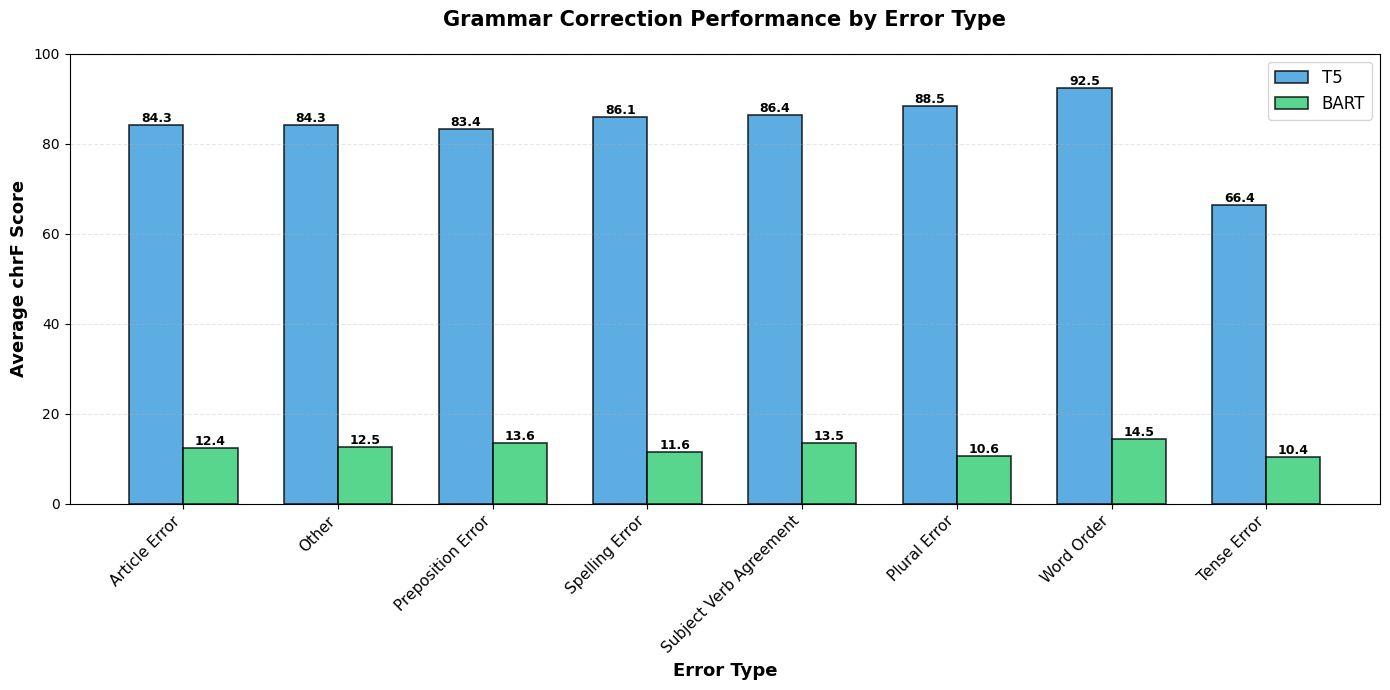

In [19]:
error_types = error_summary_df["Error Type"].tolist()
t5_avgs = error_summary_df["T5 Avg"].tolist()
bart_avgs = error_summary_df["BART Avg"].tolist()

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(error_types))
width = 0.35

bars1 = ax.bar(x - width/2, t5_avgs, width, label='T5',
               color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, bart_avgs, width, label='BART',
               color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.2)

for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h, f'{h:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Error Type', fontsize=13, fontweight='bold')
ax.set_ylabel('Average chrF Score', fontsize=13, fontweight='bold')
ax.set_title('Grammar Correction Performance by Error Type', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(error_types, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()